# Accessing glider data via the Glider DAC API with Python

IOOS provides an [`API`](https://en.wikipedia.org/wiki/Application_programming_interface) for getting information on all the glider deployments available in the [Glider DAC](https://gliders.ioos.us/index.html).

The raw JSON can be accessed at [https://data.ioos.us/gliders/providers/api/deployment](https://data.ioos.us/gliders/providers/api/deployment) and it is quite simple to parse it with Python.

First, lets check how many glider deployments exist in the Glider DAC.

In [1]:
import requests

url = 'http://data.ioos.us/gliders/providers/api/deployment'

response = requests.get(url)

res = response.json()

print('Found {0} deployments!'.format(res['num_results']))

Found 192 deployments!


And here is the JSON of the last deployment found in the list.

In [2]:
deployments = res['results']

deployment = deployments[-1]

deployment

{'archive_safe': True,
 'attribution': '',
 'checksum': '55e4ae8c590fd408c1246de3db32d93a',
 'completed': False,
 'created': 1482263525208,
 'dap': 'http://data.ioos.us/thredds/dodsC/deployments/nanoos-uw/SG187-20140625T1330/SG187-20140625T1330.nc3.nc',
 'deployment_date': 1403703000000,
 'deployment_dir': 'nanoos-uw/SG187-20140625T1330',
 'erddap': 'http://data.ioos.us/erddap/tabledap/SG187-20140625T1330.html',
 'estimated_deploy_date': None,
 'estimated_deploy_location': None,
 'glider_name': 'SG187',
 'id': '58598be598723c1805d6edd7',
 'iso': 'http://data.ioos.us/erddap/tabledap/SG187-20140625T1330.iso19115',
 'name': 'SG187-20140625T1330',
 'operator': 'nanoos-uw',
 'sos': 'http://data.ioos.us/thredds/sos/deployments/nanoos-uw/SG187-20140625T1330/SG187-20140625T1330.nc3.nc?service=SOS&request=GetCapabilities&AcceptVersions=1.0.0',
 'thredds': 'http://data.ioos.us/thredds/catalog/deployments/nanoos-uw/SG187-20140625T1330/catalog.html?dataset=deployments/nanoos-uw/SG187-20140625T1330

The `metadata` is very rich and informative. A quick way to get to the data is to read `dap` endpoint with `iris`.

In [3]:
import iris


iris.FUTURE.netcdf_promote = True


# Get this specific glider because it looks cool ;-)
for deployment in deployments:
    if deployment['name'] == 'sp064-20161214T1913':
        url = deployment['dap']

cubes = iris.load_raw(url)

print(cubes)

0: northward_sea_water_velocity / (m s-1) (-- : 1; -- : 64)
1: lat Variable Quality Flag / (1)     (-- : 1; -- : 64; -- : 216)
2: latitude Variable Quality Flag / (1) (-- : 1; -- : 64; -- : 216)
3: sea_water_density / (kg m-3)        (-- : 1; -- : 64; -- : 216)
4: sea_water_electrical_conductivity / (S m-1) (-- : 1; -- : 64; -- : 216)
5: longitude Variable Quality Flag / (1) (-- : 1; -- : 64; -- : 216)
6: precise_lon Variable Quality Flag / (1) (-- : 1; -- : 64; -- : 216)
7: Profile ID / (1)                    (-- : 1; -- : 64)
8: longitude / (degrees)               (-- : 1; -- : 64; -- : 216)
9: sea_water_pressure / (dbar)         (-- : 1; -- : 64; -- : 216)
10: sea_water_temperature / (Celsius)   (-- : 1; -- : 64; -- : 216)
11: WMO ID / (1)                        (-- : 1; -- : 64)
12: latitude / (degrees)                (-- : 1; -- : 64; -- : 216)
13: CTD Metadata / (1)                  (-- : 1; -- : 64; -- : 216)
14: precise_time Variable Quality Flag / (1) (-- : 1; -- : 64; -- : 21

/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'profile_time_qc', referenced by netCDF variable 'time'
  warnings.warn(message % (name, nc_var_name))
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'profile_lat_qc', referenced by netCDF variable 'latitude'
  warnings.warn(message % (name, nc_var_name))
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'profile_lon_qc', referenced by netCDF variable 'longitude'
  warnings.warn(message % (name, nc_var_name))
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:280: UserWarning: Missing CF-netCDF ancillary data variable 'lat_qc', referenced by netCDF variable 'precise_lat'
  warnings.warn(message % (name, nc_var_name))
/ho

In order to plot, for example sea water temperature data, one must clean the data first for missing values

In [4]:
import numpy as np
import numpy.ma as ma
import seawater as sw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def distance(x, y, units='km'):
    if ma.isMaskedArray(x):
        x = x.filled(fill_value=np.NaN)
    if ma.isMaskedArray(y):
        y = y.filled(fill_value=np.NaN)
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def apply_range(cube_coord):
    if isinstance(cube_coord, iris.cube.Cube):
        data = cube_coord.data.squeeze()
    elif isinstance(cube_coord, (iris.coords.AuxCoord, iris.coords.Coord)):
        data = cube_coord.points.squeeze()

    actual_range = cube_coord.attributes.get('actual_range')
    if actual_range is not None:
        vmin, vmax = actual_range
        data = ma.masked_outside(data, vmin, vmax)
    return data


def plot_glider(cube, cmap=plt.cm.viridis,
                figsize=(9, 3.75), track_inset=False):

    data = apply_range(cube)
    x = apply_range(cube.coord(axis='X'))
    y = apply_range(cube.coord(axis='Y'))
    z = apply_range(cube.coord(axis='Z'))
    t = cube.coord(axis='T')
    t = t.units.num2date(t.points.squeeze())

    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y)
    z = ma.abs(z)
    dist, _ = np.broadcast_arrays(dist[..., np.newaxis],
                                  z.filled(fill_value=np.NaN))
    dist, z = map(ma.masked_invalid, (dist, z))
    cs = ax.pcolor(dist, z, data, cmap=cmap, snap=True)
    kw = dict(orientation='horizontal', extend='both', shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    if track_inset:
        axin = inset_axes(
            ax, width=2, height=2, loc=4,
            bbox_to_anchor=(1.15, 0.35),
            bbox_transform=ax.figure.transFigure
        )
        axin.plot(x, y, 'k.')
        start, end = (x[0], y[0]), (x[-1], y[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')

    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Depth (m)')
    return fig, ax, cbar

The functions above apply the `actual_range` metadata to the data, mask the invalid/bad values, and prepare the parameters for plotting.

The figure below shows the temperature slice (left), and glider track (right) with start and end points marked with green and red respectively.

Note: This glider was deployed off the west of the U.S.

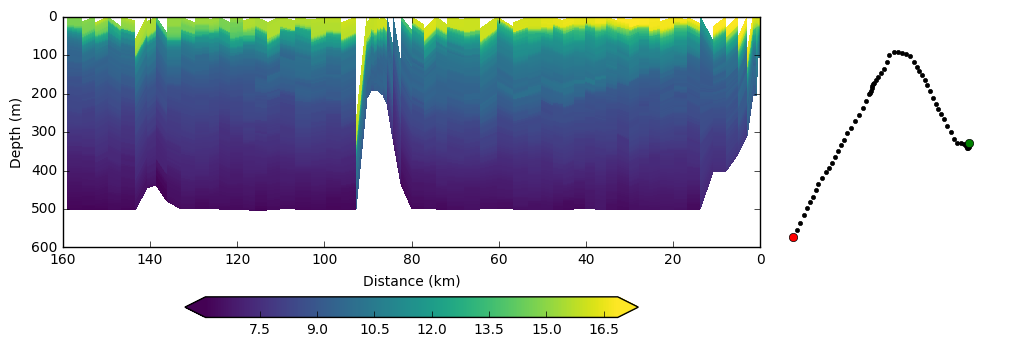

In [5]:
%matplotlib inline

temp = cubes.extract_strict('sea_water_temperature')

fig, ax, cbar = plot_glider(temp, cmap=plt.cm.viridis,
                            figsize=(9, 4.25), track_inset=True)

There are many things the user can do with the API.
Here is another example that finds all glider deployments within a boundary box.

In [6]:
bbox = [
    [-125.72, 32.60],
    [-117.57, 36.93]
]

The cell below defines two helper functions to parse the geometry from the JSON and convert the trajectory to a shapely `LineString` to prepare the data for GIS operations later.

In [7]:
from shapely.geometry import LineString


def parse_geometry(geometry):
    """
    Filters out potentially bad coordinate pairs as returned from
    GliderDAC. Returns a safe geometry object.

    :param dict geometry: A GeoJSON Geometry object

    """
    coords = []
    for lon, lat in geometry['coordinates']:
        if lon is None or lat is None:
            continue
        coords.append([lon, lat])
    return {'coordinates': coords}


def fetch_trajectory(deployment):
    """
    Downloads the track as GeoJSON from GliderDAC

    :param dict deployment: The deployment object as returned from GliderDAC

    """
    track_url = 'http://data.ioos.us/gliders/status/api/track/{}'.format
    response = requests.get(track_url(deployment['deployment_dir']))
    if response.status_code != 200:
        raise IOError("Failed to get Glider Track for %s" % deployment['deployment_dir'])
    geometry = parse_geometry(response.json())
    coords = LineString(geometry['coordinates'])
    return coords

Now it is easy to check which tracks lie inside the box.

In [8]:
from shapely.geometry import box

search_box = box(bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1])

inside = dict()
for deployment in response.json()['results']:
    try:
        coords = fetch_trajectory(deployment)
    except IOError:
        continue
    if search_box.intersects(coords):
        inside.update({deployment['name']: coords})

Finally, we can create an interactive map displaying the tracks found in the bounding box.

In [9]:
def plot_track(coords, name, color='orange'):
    x, y = coords.xy
    locations = list(zip(y.tolist(), x.tolist()))

    folium.CircleMarker(locations[0], fill_color='green', radius=10).add_to(m)
    folium.CircleMarker(locations[-1], fill_color='red', radius=10).add_to(m)

    folium.PolyLine(
        locations=locations,
        color=color,
        weight=8,
        opacity=0.2,
        popup=name
    ).add_to(m)

In [10]:
import folium


tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

location = [search_box.centroid.y, search_box.centroid.x]

m = folium.Map(
    location=location,
    zoom_start=5,
    tiles=tiles,
    attr='ESRI'
)


for name, coords in inside.items():
    plot_track(coords, name, color='orange')

m